### An Introduction to Hive Plots

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.lines import Line2D

from hiveplotlib import hive_plot_n_axes
from hiveplotlib.converters import networkx_to_nodes_edges
from hiveplotlib.viz import hive_plot_viz

#### Motivation: Why Hive Plots?

When doing an exploratory analysis of network data, analysts frequently find themselves facing one of two problems when trying to plot the network:

- The resulting plot can only be described as an uninformative "hairball."

- There are some anecdotal patterns in the visualization, but no inference can be made since the patterns may only exist by the [construction of the visualization](http://www.hiveplot.com/img/networklayouts.png).

[Hive Plots](http://www.hiveplot.com/) generate well-defined figures, allowing for reliable, visual explorations of network data.

#### Structure of Basic Hive Plots

Abstract networks inherently have no _true_ location of any node. Consequently, for any network visualization, different algorithms rely on different assumptions about how to _place_ the nodes in a figure. Some of these algorithms are more straightforward-- for example, circular layouts simply place the nodes in a circle. There are plenty of more complicated algorithms to choose from as well, such as [force-directed / spring layouts](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html#networkx.drawing.layout.spring_layout) and [spectral layouts](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.layout.spectral_layout.html#networkx.drawing.layout.spectral_layout). In both the simple and the complex cases though, the lack of control over the resulting figures limits one's ability to draw visual conclusions.

Although these more complex methods can certainly be a powerful starting point for visual exploration of a network, how can we extend their results visually? Suppose our figure implies a set of loosely connected clusters. How connected are those clusters to the other clusters? How connected are values within the cluster to values in the _same_ cluster? Hive Plots allow us to ask these questions with stable, easily-interpretable figures.

Hive Plots rely on the decision to have user-specified _axes_ in the resulting figure. These axes have minimal restrictions in their choosing; all we really need is a partition of the nodes to make it clear which node is assigned to which axis. Examples of what could be used include:

- Data values. For example, if working with biology data, partitioning a protein value into low, medium, and high.

- Graph features. For example, sinks (only edges directed _to_ them), sources (only edges directed _from_ them), and nodes that are both sinks and sources.

- Categorical labels. These labels could be ordered or unordered, as long as they still partition the nodes. Examples of this could be group memberships or political party affiliation.

To place nodes on the axes, we need an _ordering_ procedure for each axis, which has nearly the same flexibility as axis assignment:

- Data values. Rather than partitioning the values into bins, here we would use the ordering that results from the raw data.

- Graph features. We could use continuous graph features like degree or page rank.

(Note, we could still use categorical labels, as long as the categories had an ordering / we set an ordering.)

Once we've placed our nodes on axes, we simply draw the connections and analyze our resulting figure.

#### A Simple Example: Hive Plots vs Circular and Spring Layouts

As a simple example, let's explore visualizations of synthetic network data with 3 ground-truth groups that are connected both within groups and between groups with undirected edges.

In [2]:
rng = np.random.default_rng(0)

# 3 "clusters"
num_clusters = 3

# edges within each cluster
num_edges_per_cluster = [30, 60, 90]

# edges between any nodes
num_misc_edges = 20

# number of points in each cluster
pts_per_cluster = 50

# build nodes and edges
node_ids = []
edges = []

# also track the "true" group assignment
group = []
for i, num_edges in zip(range(num_clusters), num_edges_per_cluster, strict=False):
    within_node_ids = list(np.arange(pts_per_cluster) + (i * pts_per_cluster))
    node_ids += within_node_ids
    edges.append(rng.choice(within_node_ids, size=num_edges * 2).reshape(-1, 2))
    group += [i] * pts_per_cluster

# add some miscellaneous connections between any of the edges
edges.append(rng.choice(node_ids, size=num_misc_edges * 2).reshape(-1, 2))

edges = np.vstack(edges)

# put into networkx format for networkx viz
G = nx.Graph()
G.add_nodes_from(node_ids)
G.add_edges_from(list(edges))

We've established a few relationships by this construction:

1) There are increasingly more connections within groups as we look at Group 0, then Group 1, then Group 2.

2) There are some _inter_-group connections, but not as many compared to _intra_-group connections

Now, let's ask the question:

> **To what extent can we visualize these relationships with standard graph layouts as well as Hive Plots?**

#### Circular Layout

Let's start with a straightforward circular layout.

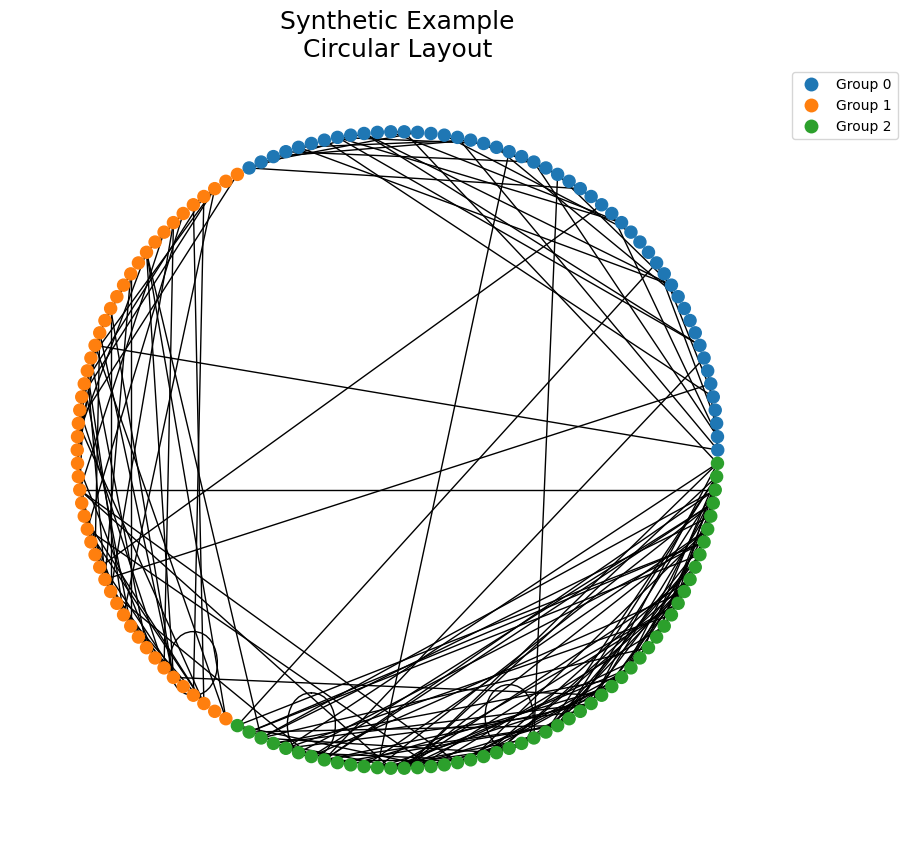

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.circular_layout(G)
colors = [f"C{i}" for i in group]
nx.draw_networkx_nodes(G, pos, ax=ax, node_color=colors, node_size=75)
nx.draw_networkx_edges(G, pos, ax=ax, edge_color="black")

# legend
custom_lines = [
    Line2D(
        [0],
        [0],
        markerfacecolor=f"C{i}",
        markeredgecolor="None",
        marker="o",
        linestyle="None",
        markersize=10,
    )
    for i in range(num_clusters)
]
custom_labels = [f"Group {i}" for i in range(num_clusters)]

ax.legend(custom_lines, custom_labels, loc="upper left", bbox_to_anchor=(1, 1))

ax.set_title("Synthetic Example\nCircular Layout", fontsize=18)
ax.axis("off")

plt.show()

For our goal of observing the two basic relationships that we established, this does a decent job. By ordering nodes by group assignment, relative connectivity within each group is intuitively possible, as are inter-group connections.

The biggest problem with this layout though is that closer nodes get shorter, harder to distinguish chords as edges. Paying a visual price trying to observe connections on nearby nodes limits the extent to which we can extend this figure with more information.

Suppose we wanted to explore these relationships with an additional sorting variable, say node degree. We wouldn't want to simply sort each group on degree, since more of the edges would be small chords. We could alternate placement of high-degree nodes on either side of the group, but then many of the inter-group connections would become small chords.

#### Spring Layout

Let's next turn our attention to a spring layout.

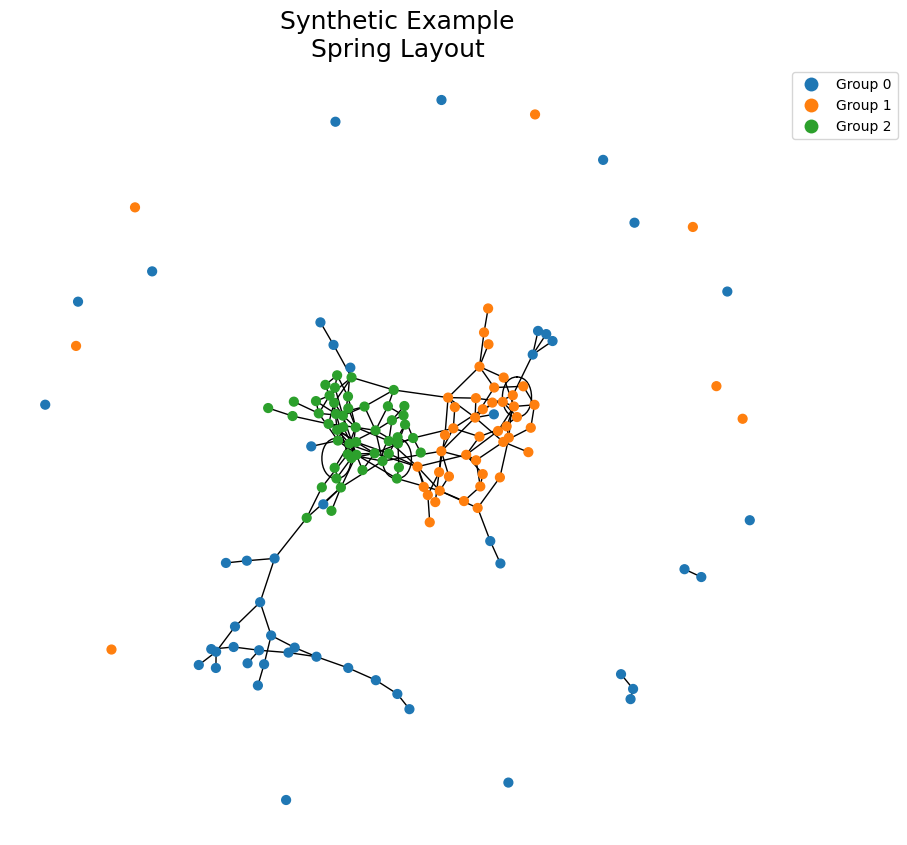

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.spring_layout(G, seed=0)
colors = [f"C{i}" for i in group]
nx.draw_networkx_nodes(G, pos, ax=ax, node_color=colors, node_size=40)
nx.draw_networkx_edges(G, pos, ax=ax, edge_color="black")

# legend
custom_lines = [
    Line2D(
        [0],
        [0],
        markerfacecolor=f"C{i}",
        markeredgecolor="None",
        marker="o",
        linestyle="None",
        markersize=10,
    )
    for i in range(num_clusters)
]
custom_labels = [f"Group {i}" for i in range(num_clusters)]

ax.legend(custom_lines, custom_labels, loc="upper left", bbox_to_anchor=(1, 1))

ax.set_title("Synthetic Example\nSpring Layout", fontsize=18)
ax.axis("off")

plt.show()

This layout does well with the intra- and inter-group relationships. Unfortunately it is even less extensible than the circular layout to any type of sorting on other variables. If we wanted to additionally visualize these relationships with node degree, we'd have to mess with transparency or shade of color. Barring a particularly strong positive or negative correlation between groups and node degree, however, this would be asking too much of someone in interpreting a figure.

Moreover, the spring layout isn't a _unique_ visualization. Without a unique output, one cannot say with as much confidence what the resulting figure _should_ look like, even if there are pre-defined relationships.

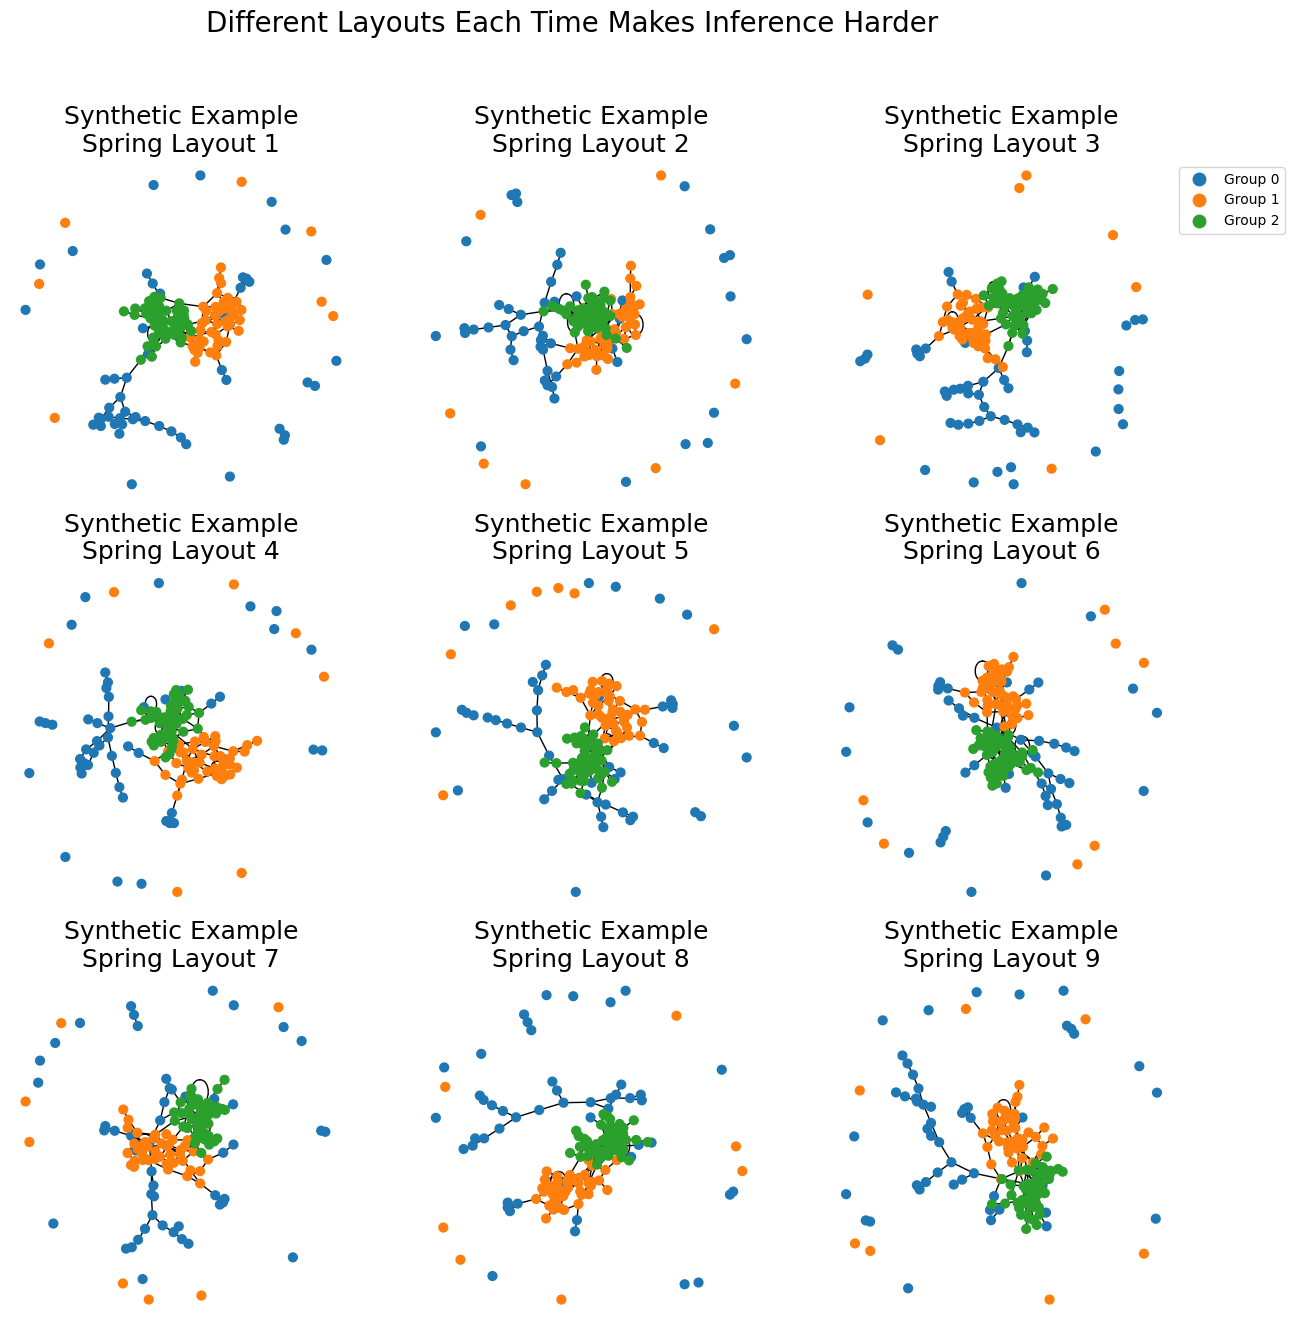

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
colors = [f"C{i}" for i in group]


for i, ax in enumerate(axes.flatten()):
    # construct the spring layout each time, which leads to differences
    pos = nx.spring_layout(G, seed=i)

    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=colors, node_size=40)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color="black")

    # legend
    if i == 2:
        custom_lines = [
            Line2D(
                [0],
                [0],
                markerfacecolor=f"C{i}",
                markeredgecolor="None",
                marker="o",
                linestyle="None",
                markersize=10,
            )
            for i in range(num_clusters)
        ]
        custom_labels = [f"Group {i}" for i in range(num_clusters)]

        ax.legend(custom_lines, custom_labels, loc="upper left", bbox_to_anchor=(1, 1))

    ax.set_title(f"Synthetic Example\nSpring Layout {i + 1}", fontsize=18)
    ax.axis("off")

plt.suptitle("Different Layouts Each Time Makes Inference Harder", fontsize=20)
plt.show()

#### Hive Plots

Hive Plots give us full control of node placement and relationships to explore with our choice of axes. Furthermore, with the ability to choose sorting procedures on axes, any additional relationships can be clearly visualized.

Let's start by looking at intra- and inter-group behavior without any other meaningful sorting. To place the nodes on each axis, we will simply place them based on their numerical IDs for the moment.

Note, for more on our use of the `hiveplotlib.hive_plot_n_axes()` method, see the [Quick Start Hive Plots](https://hiveplotlib.readthedocs.io/stable/quick_hive_plots.html) notebook. The low-level API is demonstrated in the [Basic Usage](https://hiveplotlib.readthedocs.io/stable/basic_usage.html) notebook.

/tmp/ipykernel_603364/1952512267.py:19: DeprecationWarning: hive_plot_n_axes is being deprecated in favor of the revised HivePlot class. It will be removed in v0.28.0.
  hp = hive_plot_n_axes(


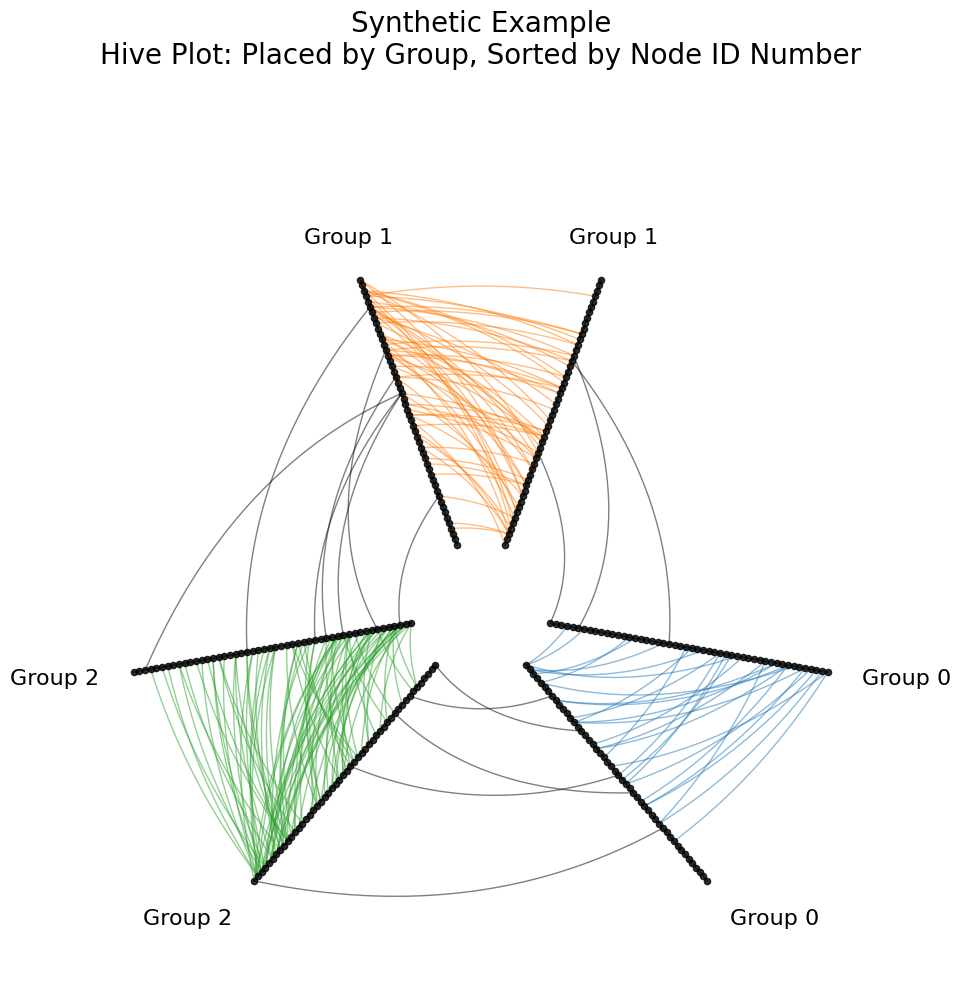

In [6]:
# convert `networkx` graph into `hiveplotlib`-ready nodes and edges
nodes, edges = networkx_to_nodes_edges(G)

# pull out degree information from nodes
degrees = dict(G.degree)

# add degree information to Node instances
for node in nodes:
    node.add_data(data={"degree": degrees[node.unique_id]})

# also store node id as data for later use
for node in nodes:
    node.add_data(data={"loc": node.unique_id})

# partition nodes by group (we generated groups sequentially)
group_ids = np.split(np.arange(pts_per_cluster * num_clusters), num_clusters)

# Hive Plot
hp = hive_plot_n_axes(
    node_list=nodes,
    edges=edges,
    axes_assignments=group_ids,
    sorting_variables=["loc"] * 3,
    axes_names=["Group 0", "Group 1", "Group 2"],
    all_edge_kwargs={"lw": 1},
    repeat_axes=[True] * 3,
    orient_angle=-30,
)

# line up intragroup connections with colors used for each group above
#  (note, above method builds intra-group connections in one direction,
#   as it would be redundant to build in both directions)
hp.add_edge_kwargs(
    axis_id_1="Group 0", axis_id_2="Group 0_repeat", a2_to_a1=False, color="C0"
)
hp.add_edge_kwargs(
    axis_id_1="Group 1", axis_id_2="Group 1_repeat", a2_to_a1=False, color="C1"
)
hp.add_edge_kwargs(
    axis_id_1="Group 2", axis_id_2="Group 2_repeat", a2_to_a1=False, color="C2"
)

# plot
fig, ax = hive_plot_viz(hp)

ax.set_title(
    "Synthetic Example\nHive Plot: Placed by Group, Sorted by Node ID Number",
    fontsize=20,
    y=1.2,
)

plt.show()

Already, we can clearly see exactly how each group interacts with the other two groups.

To see how each group interacts within its own group, we use _repeated axes_. Thus, we can clearly distinguish both types of behavior.

This methodology nicely extends to more informed sorting procedures. Let's try sorting nodes on degree for each axis and re-plotting.

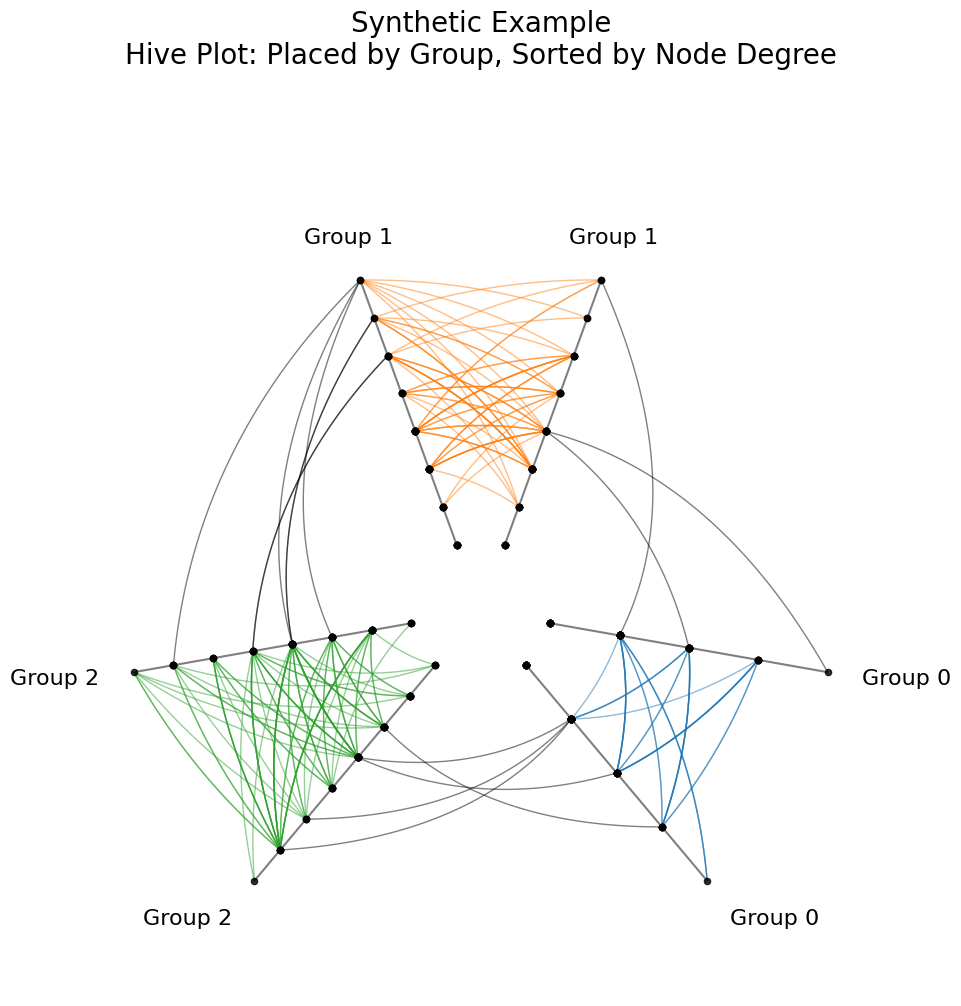

In [7]:
# re-place nodes on axis under new sorting protocol
for axis in hp.axes:
    hp.place_nodes_on_axis(axis_id=axis, sorting_feature_to_use="degree")

# rebuild edges curves now that we re-placed nodes
#  (ids of edge connections and plotting kwargs were preserved
#   only need to re-draw curves)
hp.construct_curves()

# plot
fig, ax = hive_plot_viz(hp)

ax.set_title(
    "Synthetic Example\nHive Plot: Placed by Group, Sorted by Node Degree",
    fontsize=20,
    y=1.2,
)

plt.show()

Unsurprisingly, there is no strong pattern here since we randomly chose our connections for intra- and inter-group, but the important point to make here is that this methodology can be used to visually ask these sorts of questions. We explore this question of degree relationships further in our example on <a href="https://hiveplotlib.readthedocs.io/stable/public/karate_club.html"> Zachary's Karate Club</a>.